1
2
3
4
5
6
MSE : 0.2984358669374628


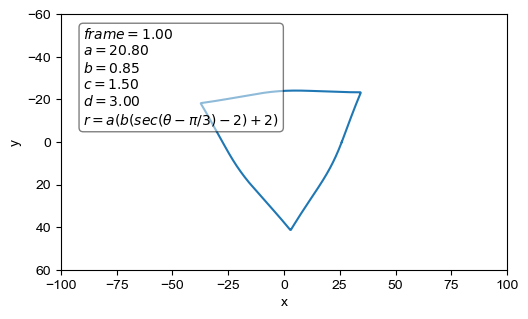

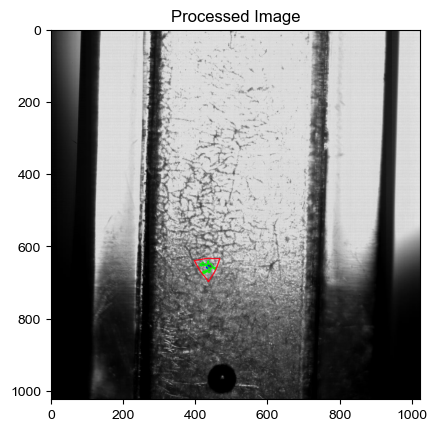

MSE : 0.2764013440597231


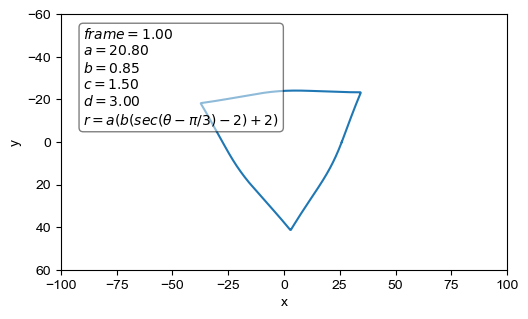

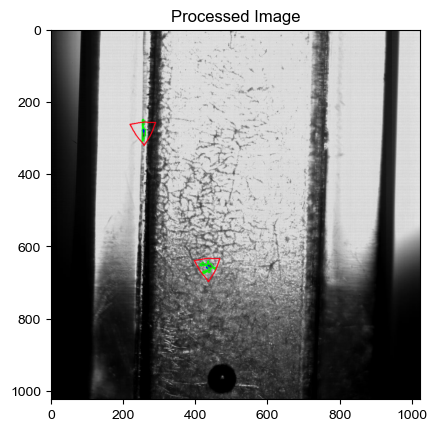

MSE : 0.3857669067771405


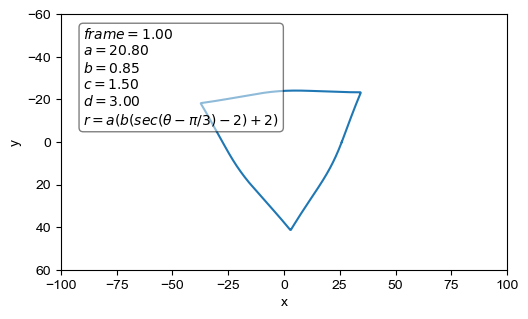

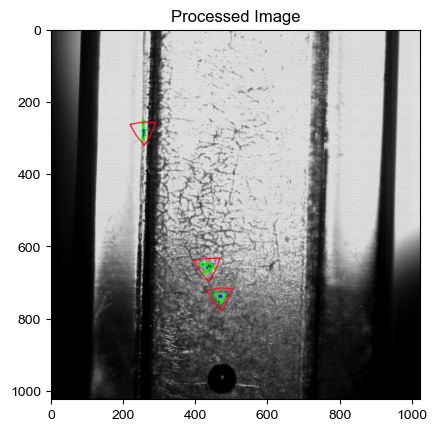

MSE : 0.28727613178539174


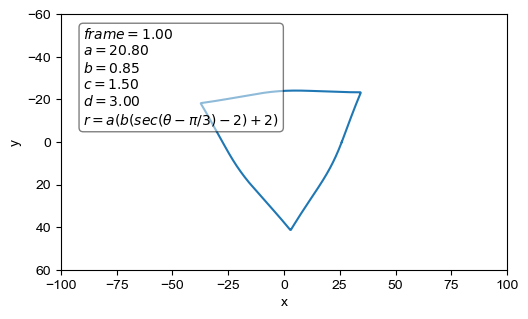

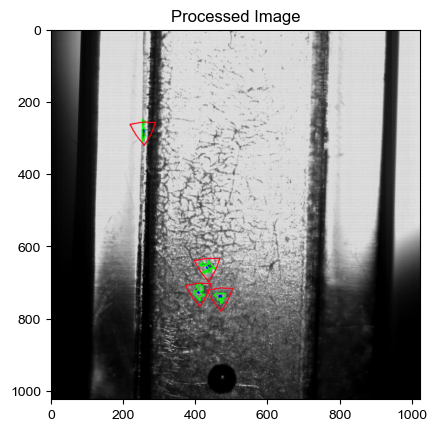

MSE : 0.4398738201548308


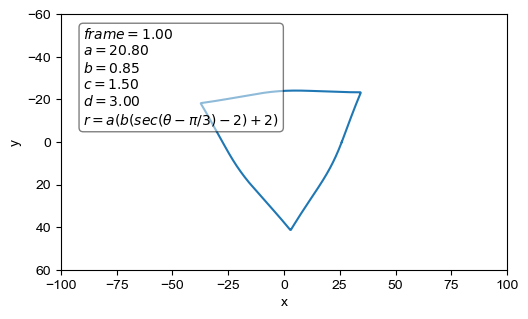

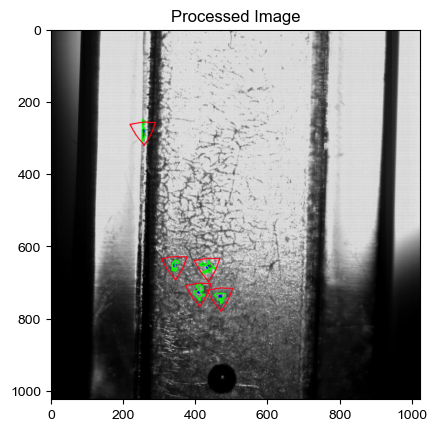

MSE : 0.25247773635044624


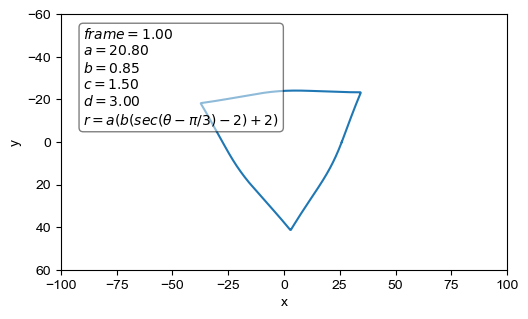

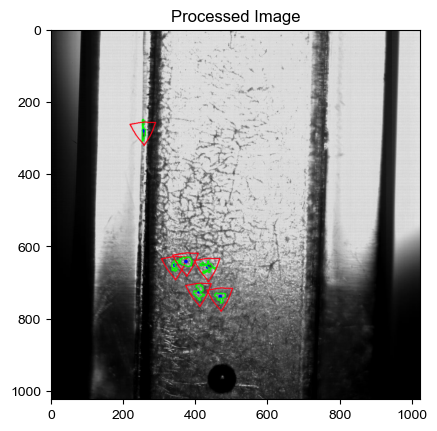

In [12]:
#動画内で気になるフレームがあったときに確認するプログラム
#inputに確認したいフレームの数字を入力
#a,b,c,dを手入力。そのときの関数を画像の上にプロットして、そのときのMSEの値を出力
#動画に対して処理する。
#指定したフレーム分を処理する。
import cv2
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize


def objectiveFunction(params, d, theta_cal, r_obs):
    a, b, c = params
    r_cal = []
    for i, _ in enumerate(theta_cal):
        theta_prime = (d / 3 * theta_cal[i] - c) % (np.pi / 1.5)
        r_cal.append(a * (b * (1 / np.cos(theta_prime - np.pi / 3) - 2) + 2))
    
    MSE = np.mean(((np.array(r_obs) - np.array(r_cal)) / np.array(r_cal) )** 2)
    return MSE

def drawContour(params, d, target_frame,result_image, moment):
    a, b, c = params
    r = []
    theta = np.linspace(0, 2 * np.pi, 1000)
    for i, _ in enumerate(theta):
        theta_prime = (d / 3 * theta[i] - c) % (np.pi / 1.5)
        r.append(a * (b * (1 / np.cos(theta_prime - np.pi / 3) - 2) + 2))
    
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(2, 2, 1)
    plt.rcParams["font.family"] = "Arial"
    ax.plot(x, y)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
    textstr = '\n'.join((
        r'$frame=%.2f$' % (target_frame,),
        r'$a=%.2f$' % (a,),
        r'$b=%.2f$' % (b,),
        r'$c=%.2f$' % (c,),
        r'$d=%.2f$' % (d,),
        r'$r=a(b(sec(θ - π/3)-2)+2)$'
    ))
    #result_imageに対してcalculated_contourを描画
    # 座標を整数に変換し、列方向にスタック
    smooth_contour = np.column_stack((x.astype(int), y.astype(int)))

    # reshapeしてcontourの形式に変換
    smooth_contour = smooth_contour.reshape((-1, 1, 2))
    smooth_contour += moment
    # 描画
    cv2.drawContours(result_image, [smooth_contour], -1, (255, 0, 20), 2)
    cv2.imshow("Coincidence of both", result_image)
    
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=props)
    ax.set_xlim([-100, 100])
    ax.set_ylim([-60, 60])
    ax.invert_yaxis()
    plt.tight_layout()
    #plt.savefig("/Users/nametakouhei/name/画像ファイル/保存データ/四面体/Predicted_Contour/image_{}.jpg".format(target_frame))
    plt.show()
    plt.close()

# main関数
#cap = cv2.VideoCapture('/Users/nametakouhei/name/画像ファイル/四面体.avi')
#total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
image_path = "/Users/nametakouhei/name/画像ファイル/高木test.jpg"
# 処理したいフレームの番号（例: 100フレーム目）
target_frame = 1

# 指定したフレームに移動
#cap.set(cv2.CAP_PROP_POS_FRAMES, target_frame)

#変更するパラメータ
params = [20.8,0.85,1.5]
d = 3

#フレームを一つ読み込む
#ret, frame = cap.read() 
ret,frame = True, cv2.imread(image_path)
if not ret or frame is None:
    print("Error: Failed to load image from the video")
    sys.exit(1)
if ret:
    #前処理分の部分
    gray_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.bilateralFilter(gray_image, 7, 15, 15)
    denoised_image = cv2.medianBlur(blurred_image, 5)
    #ここまでは同じ
    ret, binary = cv2.threshold(denoised_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    #輪郭検出の部分
    contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    conditions = {"min_contour_area": 300, "max_contour_area": 12000}
    center_x, center_y = gray_image.shape[1] // 2, gray_image.shape[0] // 2  
    max_distance_from_center = 150  # 中央からの最大距離, 位置フィルタリングのために利用する。
    #フィルタリングの部分
    filtered_contours = []
    moment_data = []
    for _, contour in enumerate(contours):
        contour_area = cv2.contourArea(contour)
        M = cv2.moments(contour)
        filtered_cx = int(M['m10'] / M['m00']) if M["m00"] != 0 else 0
        filtered_cy = int(M['m01'] / M['m00']) if M["m00"] != 0 else 0
        #distance_from_center = np.sqrt((filtered_cx - center_x)**2 + (filtered_cy - center_y)**2)
        
        if (
            ("min_contour_area" not in conditions or contour_area >= conditions["min_contour_area"]) and
            ("max_contour_area" not in conditions or contour_area <= conditions["max_contour_area"]) 
            #(distance_from_center <= max_distance_from_center)
        ):
            filtered_contours.append(contour)
            print(len(filtered_contours))
            moment_data.append((filtered_cx, filtered_cy))

    result_image = frame.copy() #コピーする。これはなぜ？
    MSE_standard = float('inf')
    params_result = [0, 0, 0]
    for contour, moment in zip(filtered_contours, moment_data):
        M = cv2.moments(contour)
        rel_con = []

        if M["m00"] != 0:
            filtered_cx, filtered_cy = moment
            #result_imageに輪郭座標をプロット
            cv2.circle(result_image, (filtered_cx, filtered_cy), 5, (0, 0, 255), -1)
            cv2.drawContours(result_image, [contour], -1, (0, 255, 0), 2)
            #重心からの輪郭相対位置を計算
            rel_con = contour - moment

        con_x = []
        con_y = []

        for i, con in enumerate(rel_con):
            con_x.append(con[0][0])
            con_y.append(con[0][1])

        r_obs = [np.sqrt(x**2 + y**2) for x, y in zip(con_x, con_y)]
        theta_obs = [np.arctan2(y, x) for x, y in zip(con_x, con_y)]
        theta_cal = theta_obs
        MSE = objectiveFunction(params, d, theta_cal, r_obs)
        print("MSE : " + str(MSE))
        drawContour(params,d,target_frame,result_image,moment)


        
        plt.imshow(result_image)
        plt.title('Processed Image')
        #plt.savefig("/Users/nametakouhei/name/画像ファイル/保存データ/四面体/Processed_image/image_{}.png".format(frame_number))
        plt.show()
        plt.close()
